# Three-particle problem

In [ ]:
%reload_ext lab_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import complex_ode

from quantum_systems import ODQD, GeneralOrbitalSystem
from quantum_systems.time_evolution_operators import TimeEvolutionOperator

from configuration_interaction import CISDT, TDCISDT
from configuration_interaction.ci_helper import state_printer

from gauss_integrator import GaussIntegrator

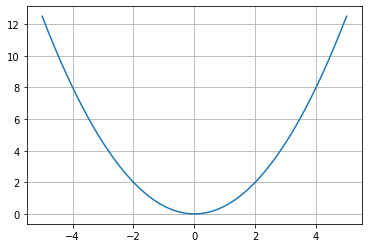

In [3]:
omega = 1

n = 3
l = 3
soft_coulomb = 1
kappa = 1

potential = ODQD.HOPotential(omega=omega)

grid_length = 5
num_grid_points = 2001
grid = np.linspace(-grid_length, grid_length, num_grid_points)

plt.plot(grid, potential(grid))
plt.grid()

plt.show()

In [4]:
system = GeneralOrbitalSystem(
    n,
    ODQD(
        l,
        grid_length,
        num_grid_points,
        a=soft_coulomb,
        alpha=kappa,
        potential=potential,
    ),
)

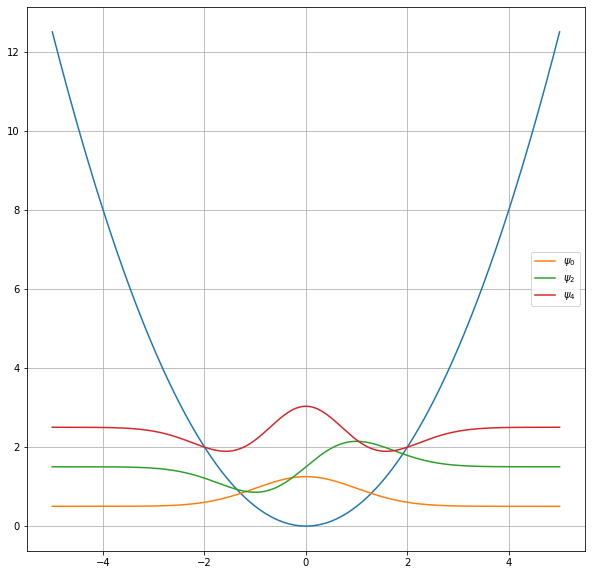

In [5]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, potential(grid))

for i in range(0, system.l, 2):
    plt.plot(
        system.grid,
        system.spf[i].real + system.h[i, i].real,
        "-" if i % 2 == 0 else "--",
        label=rf"$\psi_{i}$",
    )

plt.grid()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))

spin_2_tb = system.spin_2_tb.reshape(int(system.l ** 2), int(system.l ** 2)).real
extent = (0, spin_2_tb.shape[1], spin_2_tb.shape[0], 0)

cmap = plt.get_cmap("jet", np.max(spin_2_tb) - np.min(spin_2_tb) + 1)

mat = ax.imshow(
    spin_2_tb,
    interpolation="none",
    vmin=0,
    vmax=2,
    aspect="equal",
    extent=extent,
    cmap=cmap,
)

fig.colorbar(mat, ax=ax, ticks=np.arange(np.min(spin_2_tb), np.max(spin_2_tb) + 1))

ax.set_xticks(np.arange(0, spin_2_tb.shape[0], 1))
ax.set_yticks(np.arange(0, spin_2_tb.shape[1], 1))

ax.grid(color="w", linewidth=2)
ax.set_frame_on(False)

plt.show()

Hmmm, below we check if the $\hat{S}^2$ matrix varies depending on construction method.

spin_dir_tb_orig = []
spin_dir_tb_pm = []

spin_p = system.spin_x + 1j * system.spin_y
spin_m = system.spin_x - 1j * system.spin_y

for spin in [system.spin_x, system.spin_y, system.spin_z]:
    spin_dir_tb_orig.append(np.kron(spin, system.s) + np.kron(system.s, spin))

for spin in [spin_p, spin_m, system.spin_z]:
    spin_dir_tb_pm.append(np.kron(spin, system.s) + np.kron(system.s, spin))

spin_2 = sum(map(lambda x: x @ x, spin_dir_tb_orig)).reshape(system.spin_2.shape)
spin_2_mp = (
    spin_dir_tb_pm[1] @ spin_dir_tb_pm[0]
    + spin_dir_tb_pm[2]
    + spin_dir_tb_pm[2] @ spin_dir_tb_pm[2]
).reshape(system.spin_2.shape)
spin_2_pm = (
    spin_dir_tb_pm[0] @ spin_dir_tb_pm[1]
    - spin_dir_tb_pm[2]
    + spin_dir_tb_pm[2] @ spin_dir_tb_pm[2]
).reshape(system.spin_2.shape)

np.testing.assert_allclose(spin_2, system.spin_2)
np.testing.assert_allclose(spin_2_mp, system.spin_2)
np.testing.assert_allclose(spin_2_pm, system.spin_2)

In [6]:
cisdt = CISDT(system, verbose=False).compute_ground_state()

In [7]:
print(cisdt.energies)

[4.49891343 4.49891343 5.30798154 5.30798154 5.51436602 5.51436602
 6.11038016 6.11038016 6.11038016 6.11038016 6.32609391 6.32609391
 6.45887549 6.45887549 7.1523374  7.1523374  7.35854662 7.35854662
 8.17690149 8.17690149]


In [8]:
print(system.h.real)

[[0.49999922 0.         0.         0.         0.         0.        ]
 [0.         0.49999922 0.         0.         0.         0.        ]
 [0.         0.         1.4999961  0.         0.         0.        ]
 [0.         0.         0.         1.4999961  0.         0.        ]
 [0.         0.         0.         0.         2.49998993 0.        ]
 [0.         0.         0.         0.         0.         2.49998993]]


In [9]:
dets = []

for i, state in enumerate(cisdt.states):
    dets.append(f"|{state_printer(state)[52:]}>")
    # print(f"|Phi_{i}> = {dets[-1]}")

In [10]:
eigs = []

for i in range(cisdt.num_states):
    comb = f"|Psi_{i}> = "
    for j, coeff in enumerate(cisdt.C[:, i]):
        if abs(coeff) < 1e-10:
            continue

        comb += f"({coeff}){dets[j]}  +  "

    comb = comb[:-5]
    eigs.append(comb)
    # print(comb)
    print(f"|Psi_{i}>")
    print(f"\tE({i}) = {cisdt.energies[i]:.4f} (eigval)")
    print(f"\tS_z({i}) = {cisdt._s_z[i]:.4f} (eigval)")
    print(f"\tS^2({i}) = {cisdt._s_2[i]:.4f} (eigval)")
    print(
        f"\t<Psi_{i}|H|Psi_{i}>  =  {cisdt.compute_one_body_expectation_value(system.h, K=i).real + 0.5 * cisdt.compute_two_body_expectation_value(system.u, K=i).real:.4f} (expectation value)"
    )
    print(
        f"\t<Psi_{i}|S_z|Psi_{i}>  =  {cisdt.compute_one_body_expectation_value(system.spin_z, K=i).real:.4f} (expectation value)"
    )
    print(
        f"\t<Psi_{i}|S^2|Psi_{i}>  =  {(cisdt.compute_one_body_expectation_value(system.spin_2, K=i) + cisdt.compute_two_body_expectation_value(system.spin_2_tb, K=i)).real:.4f} (expectation value)"
    )

    # S_2_sb = sum(map(lambda x: x @ x, [system.spin_x, system.spin_y, system.spin_z]))
    # S_2_sb_exp = cisdt.compute_one_body_expectation_value(S_2_sb, K=i)
    # S_2_tb_exp = cisdt.compute_two_body_expectation_value(system.spin_2, K=i)
    # print(S_2_sb_exp + 0.25 * S_2_tb_exp)

|Psi_0>
	E(0) = 4.4989 (eigval)
	S_z(0) = -0.5000 (eigval)
	S^2(0) = 0.7500 (eigval)
	<Psi_0|H|Psi_0>  =  4.4989 (expectation value)
	<Psi_0|S_z|Psi_0>  =  -0.5000 (expectation value)
	<Psi_0|S^2|Psi_0>  =  0.7500 (expectation value)
|Psi_1>
	E(1) = 4.4989 (eigval)
	S_z(1) = 0.5000 (eigval)
	S^2(1) = 0.7500 (eigval)
	<Psi_1|H|Psi_1>  =  4.4989 (expectation value)
	<Psi_1|S_z|Psi_1>  =  0.5000 (expectation value)
	<Psi_1|S^2|Psi_1>  =  0.7500 (expectation value)
|Psi_2>
	E(2) = 5.3080 (eigval)
	S_z(2) = -0.5000 (eigval)
	S^2(2) = 0.7500 (eigval)
	<Psi_2|H|Psi_2>  =  5.3080 (expectation value)
	<Psi_2|S_z|Psi_2>  =  -0.5000 (expectation value)
	<Psi_2|S^2|Psi_2>  =  0.7500 (expectation value)
|Psi_3>
	E(3) = 5.3080 (eigval)
	S_z(3) = 0.5000 (eigval)
	S^2(3) = 0.7500 (eigval)
	<Psi_3|H|Psi_3>  =  5.3080 (expectation value)
	<Psi_3|S_z|Psi_3>  =  0.5000 (expectation value)
	<Psi_3|S^2|Psi_3>  =  0.7500 (expectation value)
|Psi_4>
	E(4) = 5.5144 (eigval)
	S_z(4) = -0.5000 (eigval)
	S^2(4) =

E_0 = 4.4989  | <d_0> = 0.00000
	Dipole allowed 0 -> 1: [(-5.917937619134139e-16+0j)]
	Dipole allowed 0 -> 2: [(0.09065059809879278+0j)]
	Dipole allowed 0 -> 3: [(3.9546700429500905e-16+0j)]
	Dipole allowed 0 -> 4: [(1.1281456189708796+0j)]
	Dipole allowed 0 -> 5: [(7.168617532325887e-16+0j)]
	Dipole allowed 0 -> 6: [(1.6519823864194787e-16+0j)]
	Dipole allowed 0 -> 7: [(5.062348611753415e-16+0j)]
	Dipole allowed 0 -> 8: [(3.6780234899185406e-16+0j)]
	Dipole allowed 0 -> 9: [(-4.2706777731631247e-16+0j)]
	Dipole allowed 0 -> 10: [(5.626328912053299e-13+0j)]
	Dipole allowed 0 -> 11: [(1.413386361035144e-16+0j)]
	Dipole allowed 0 -> 12: [(-1.7122591589464274e-13+0j)]
	Dipole allowed 0 -> 13: [(-8.618117656141083e-16+0j)]
	Dipole allowed 0 -> 14: [(-0.0027182405723510804+0j)]
	Dipole allowed 0 -> 15: [(1.0868930930737246e-16+0j)]
	Dipole allowed 0 -> 16: [(-0.01632693842233947+0j)]
	Dipole allowed 0 -> 17: [(-8.433603068388323e-16+0j)]
	Dipole allowed 0 -> 18: [(-2.523520486681786e-14+0j)

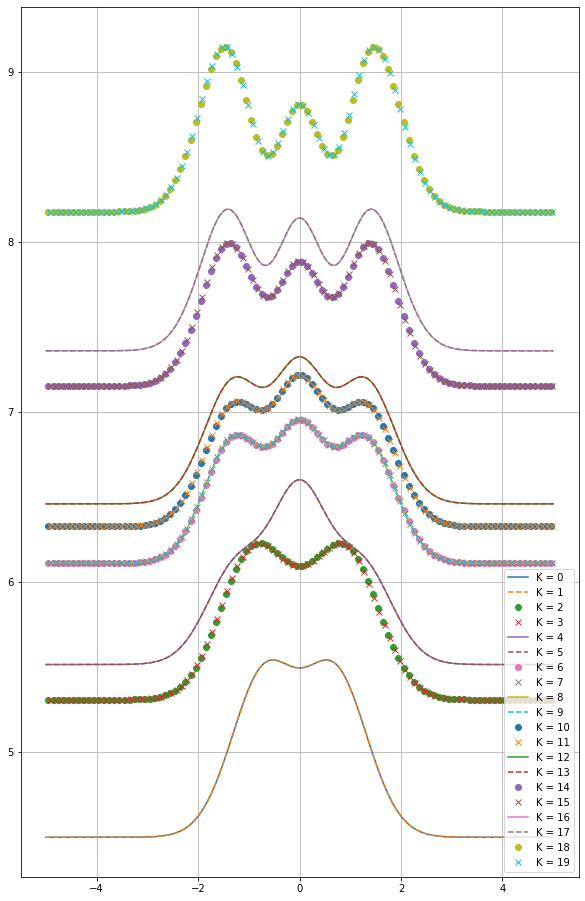

In [11]:
fig = plt.figure(figsize=(10, 16))

for I in range(min(cisdt.num_states, 20)):
    dip = cisdt.compute_one_body_expectation_value(system.dipole_moment[0], K=I)
    print(rf"E_{I} = {cisdt.energies[I]:.4f}  | <d_{I}> = {dip.real:.5f}")
    for J in range(I + 1, min(cisdt.num_states, 20)):
        print(
            f"\tDipole allowed {I} -> {J}: {cisdt.allowed_dipole_transition(I, J)}"
        )
    rho_I = cisdt.compute_particle_density(K=I).real

    fmt = ["-", "--", "o", "x"]
    plt.plot(
        system.grid,
        rho_I + cisdt.energies[I].real,
        fmt[I % 4],
        label=rf"K = {I}",
        markevery=np.arange(len(system.grid))[I % 4 * 5 :: 20],
    )
    print(f"\t(int) dx rho_{I}(x) = {np.trapz(rho_I, system.grid)}")

plt.grid()
plt.legend(loc="lower right")
plt.show()